# London Crime Data ETL Pipeline

## Objectives

* Extract London Metropolitan Police Service (MPS) ward-level crime statistics from raw CSV data
* Transform wide-format temporal data into analysis-ready formats
* Engineer derived features including crime categories, temporal aggregations, and location-based groupings
* Validate data quality and handle missing values
* Load processed data into standardized output format for downstream analysis

## Inputs

* **Primary Dataset**: `MPSCrime.csv`
  * **Location**: `data/raw/`
  * **Format**: CSV with 18,693 rows × 29 columns
  * **Temporal Coverage**: November 2023 - October 2025 (24 months)
  * **Geographical Coverage**: 669 London wards across 32 boroughs + Aviation Security
  * **Crime Classifications**: Major and minor category hierarchies

## Outputs

* **Processed Dataset**: `processed_crime_data.csv`
  * **Location**: `data/clean/`
  * **Format**: Cleaned and feature-engineered CSV
  * **Features**: Original columns plus engineered temporal and categorical features
  * **Quality**: Validated data types, handled missing values, standardized formats

## Data Processing Steps

1. **Data Loading & Initial Exploration**
   * Load raw CSV into pandas DataFrame
   * Inspect structure, dimensions, and data types
   * Identify missing values and data quality issues

2. **Data Transformation**
   * Rename crime category columns for clarity
   * Convert temporal columns from wide to long format
   * Parse date strings into datetime objects
   * Create aggregated views by ward and crime category

3. **Feature Engineering**
   * Generate crime category groupings
   * Calculate temporal aggregations (monthly totals)
   * Create location-based features

4. **Data Validation & Quality Checks**
   * Verify completeness of temporal coverage
   * Validate geographical hierarchies
   * Check for data anomalies and outliers

## Key Libraries

* **pandas**: Data manipulation and transformation
* **numpy**: Numerical operations and array handling
* **matplotlib**: Basic data visualization and validation plots

In [35]:
import pandas as pd # for data manipulation
import numpy as np # for numerical operations
import matplotlib.pyplot as plt # for data visualization

## Data Loading

Load the raw MPS crime dataset and perform initial inspection:

* **Source**: `data/raw/MPSCrime.csv`
* **DataFrame dimensions**: Rows and columns count
* **Preview**: First 5 records to verify structure and content

In [36]:
df = pd.read_csv("../data/raw/MPSCrime.csv")
print(df.shape)
df.head()

(18693, 29)


,MajorText,MinorText,WardName,WardCode,LookUp_BoroughName,202311,202312,202401,202402,202403,...,202501,202502,202503,202504,202505,202506,202507,202508,202509,202510
0,ARSON AND CRIMINAL DAMAGE,ARSON,Heathrow Villages,E05013570,Aviation Security (SO18),0,1,3,0,2,...,2,1,1,0,0,5,3,2,0,0
1,ARSON AND CRIMINAL DAMAGE,CRIMINAL DAMAGE,Heathrow Villages,E05013570,Aviation Security (SO18),17,36,25,28,21,...,28,23,27,25,15,18,25,24,30,27
2,BURGLARY,BURGLARY BUSINESS AND COMMUNITY,Heathrow Villages,E05013570,Aviation Security (SO18),1,4,2,9,6,...,3,5,2,5,6,4,1,4,2,5
3,BURGLARY,RES BURGLARY OF A HOME,Heathrow Villages,E05013570,Aviation Security (SO18),7,8,11,7,3,...,5,4,10,2,1,8,1,4,2,3
4,BURGLARY,RES BURGLARY OF UNCONNECTED BUILDING,Heathrow Villages,E05013570,Aviation Security (SO18),3,3,1,0,1,...,1,0,0,1,0,1,0,2,1,0


## Column Renaming

Rename crime classification columns for clarity:

* `MajorText` → `Crime Category`
* `MinorText` → `Specific Crime Type`

In [37]:
df = df.rename(columns={
    'MajorText': 'Crime Category',
    'MinorText': 'Specific Crime Type'
})

## Data Cleaning 

Check for missing values across all columns to assess data completeness.

In [38]:
df.isnull().sum()

Crime Category         0
Specific Crime Type    0
WardName               0
WardCode               0
LookUp_BoroughName     0
202311                 0
202312                 0
202401                 0
202402                 0
202403                 0
202404                 0
202405                 0
202406                 0
202407                 0
202408                 0
202409                 0
202410                 0
202411                 0
202412                 0
202501                 0
202502                 0
202503                 0
202504                 0
202505                 0
202506                 0
202507                 0
202508                 0
202509                 0
202510                 0
dtype: int64

Identify any duplicate rows in the dataset to ensure data integrity.

In [39]:
df.duplicated().sum()

0

## Data Quality Summary

No missing values or duplicate records detected. Proceeding to examine data types for validation.

In [40]:
df.info() # Check data types and non-null counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18693 entries, 0 to 18692
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Crime Category       18693 non-null  object
 1   Specific Crime Type  18693 non-null  object
 2   WardName             18693 non-null  object
 3   WardCode             18693 non-null  object
 4   LookUp_BoroughName   18693 non-null  object
 5   202311               18693 non-null  int64 
 6   202312               18693 non-null  int64 
 7   202401               18693 non-null  int64 
 8   202402               18693 non-null  int64 
 9   202403               18693 non-null  int64 
 10  202404               18693 non-null  int64 
 11  202405               18693 non-null  int64 
 12  202406               18693 non-null  int64 
 13  202407               18693 non-null  int64 
 14  202408               18693 non-null  int64 
 15  202409               18693 non-null  int64 
 16  2024

## Crime Category Analysis

Examine the distinct major crime categories and their associated specific crime types.


In [41]:
df['Crime Category'].unique() # List unique crime categories


array(['ARSON AND CRIMINAL DAMAGE', 'BURGLARY', 'DRUG OFFENCES',
       'MISCELLANEOUS CRIMES AGAINST SOCIETY', 'POSSESSION OF WEAPONS',
       'PUBLIC ORDER OFFENCES', 'ROBBERY', 'SEXUAL OFFENCES', 'THEFT',
       'VEHICLE OFFENCES', 'VIOLENCE AGAINST THE PERSON',
       'FRAUD AND FORGERY', 'NFIB FRAUD'], dtype=object)

In [42]:
df['Specific Crime Type'].unique() # List unique specific crime types

array(['ARSON', 'CRIMINAL DAMAGE', 'BURGLARY BUSINESS AND COMMUNITY',
       'RES BURGLARY OF A HOME', 'RES BURGLARY OF UNCONNECTED BUILDING',
       'POSSESSION OF DRUGS', 'TRAFFICKING OF DRUGS',
       'MISC CRIMES AGAINST SOCIETY', 'POSSESSION OF WEAPONS',
       'OTHER OFFENCES PUBLIC ORDER', 'PUBLIC FEAR ALARM OR DISTRESS',
       'RACE OR RELIGIOUS AGG PUBLIC FEAR', 'VIOLENT DISORDER',
       'ROBBERY OF BUSINESS PROPERTY', 'ROBBERY OF PERSONAL PROPERTY',
       'OTHER SEXUAL OFFENCES', 'RAPE', 'BICYCLE THEFT', 'OTHER THEFT',
       'SHOPLIFTING', 'THEFT FROM THE PERSON',
       'AGGRAVATED VEHICLE TAKING', 'INTERFERING WITH A MOTOR VEHICLE',
       'THEFT FROM A VEHICLE', 'THEFT OR UNAUTH TAKING OF A MOTOR VEH',
       'DEATH SERIOUS INJURY ILLEGAL DRIVING', 'HOMICIDE',
       'STALKING AND HARASSMENT', 'VIOLENCE WITH INJURY',
       'VIOLENCE WITHOUT INJURY', 'FRAUD AND FORGERY',
       'BURGLARY - RESIDENTIAL', 'NFIB'], dtype=object)

## Crime Category Groupings

Group specific crime types by their major categories to understand the hierarchical structure of crime classifications.

In [43]:
crimes = df.groupby('Crime Category')['Specific Crime Type'].unique().reset_index() # Get unique specific crime types per category
crimes

,Crime Category,Specific Crime Type
0,ARSON AND CRIMINAL DAMAGE,"[ARSON, CRIMINAL DAMAGE]"
1,BURGLARY,"[BURGLARY BUSINESS AND COMMUNITY, RES BURGLARY..."
2,DRUG OFFENCES,"[POSSESSION OF DRUGS, TRAFFICKING OF DRUGS]"
3,FRAUD AND FORGERY,[FRAUD AND FORGERY]
4,MISCELLANEOUS CRIMES AGAINST SOCIETY,[MISC CRIMES AGAINST SOCIETY]
5,NFIB FRAUD,[NFIB]
6,POSSESSION OF WEAPONS,[POSSESSION OF WEAPONS]
7,PUBLIC ORDER OFFENCES,"[OTHER OFFENCES PUBLIC ORDER, PUBLIC FEAR ALAR..."
8,ROBBERY,"[ROBBERY OF BUSINESS PROPERTY, ROBBERY OF PERS..."
9,SEXUAL OFFENCES,"[OTHER SEXUAL OFFENCES, RAPE]"


## Alternative View: Crime Classification Hierarchy

Display all unique crime category and type combinations in sorted tabular format.

In [44]:
df[['Crime Category', 'Specific Crime Type']].drop_duplicates().sort_values(['Crime Category', 'Specific Crime Type'])

,Crime Category,Specific Crime Type
0,ARSON AND CRIMINAL DAMAGE,ARSON
1,ARSON AND CRIMINAL DAMAGE,CRIMINAL DAMAGE
884,BURGLARY,BURGLARY - RESIDENTIAL
2,BURGLARY,BURGLARY BUSINESS AND COMMUNITY
3,BURGLARY,RES BURGLARY OF A HOME
4,BURGLARY,RES BURGLARY OF UNCONNECTED BUILDING
5,DRUG OFFENCES,POSSESSION OF DRUGS
6,DRUG OFFENCES,TRAFFICKING OF DRUGS
37,FRAUD AND FORGERY,FRAUD AND FORGERY
7,MISCELLANEOUS CRIMES AGAINST SOCIETY,MISC CRIMES AGAINST SOCIETY


## Temporal Data Preparation

Convert month-year column headers into proper datetime format for time series analysis.

In [45]:
# Find all month columns
month_cols = [col for col in df.columns if col.isdigit()]

# Convert string YYYYMM → datetime
dates = pd.to_datetime(month_cols, format="%Y%m")

# Replace columns with datetime versions
df.rename(columns=dict(zip(month_cols, dates)), inplace=True)

## Crime Category Trends

Aggregate crime counts by major category across all time periods to analyze temporal patterns.

In [46]:
major_pivot = df.pivot_table(
    index='Crime Category',
    values=[col for col in df.columns if isinstance(col, pd.Timestamp)],
    aggfunc='sum')

major_pivot.head()


,2023-11-01,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,...,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01,2025-08-01,2025-09-01,2025-10-01
Crime Category,,,,,,,,,,,,,,,,,,,,,
ARSON AND CRIMINAL DAMAGE,4609,4741,4820,4529,4424,4416,4560,4586,5182,4958,...,4112,4008,4476,4591,4808,4805,5214,4822,4506,4648
BURGLARY,4678,4991,5044,4385,4612,4216,4036,3878,4165,4178,...,4426,3720,3944,3595,3808,3613,3811,3972,3982,4237
DRUG OFFENCES,2867,2607,2937,2753,2578,2504,2794,2736,2907,3078,...,4080,3697,3978,4543,4897,4220,4577,4630,4291,4519
FRAUD AND FORGERY,1,0,0,1,26,23,19,17,11,6,...,4,5,4,4,2,3,1,0,0,3
MISCELLANEOUS CRIMES AGAINST SOCIETY,879,754,876,772,690,717,758,787,809,857,...,968,847,1017,1012,1043,1073,1146,1054,949,1082


## Overall Crime Volume Visualization

Plot total crime counts across all categories by month to identify temporal trends and seasonality.

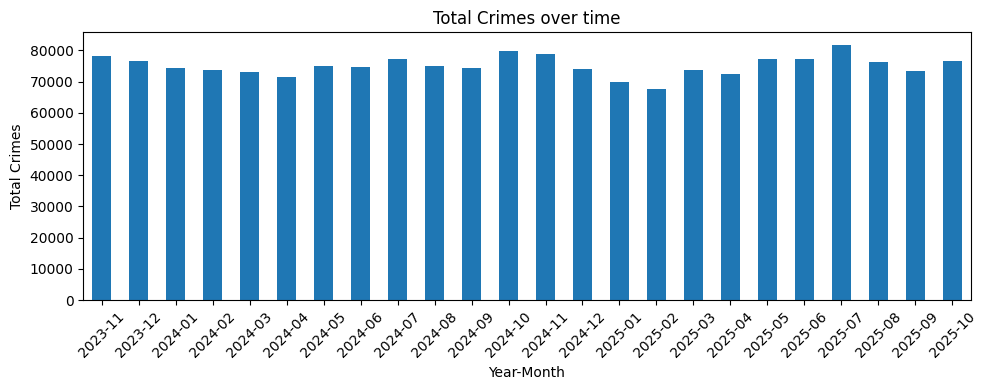

In [47]:
s = major_pivot.sum(axis=0)
plt.figure(figsize=(10, 4))
ax = s.plot(kind='bar')
ax.set_title('Total Crimes over time')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Total Crimes')
ax.set_xticklabels([dt.strftime('%Y-%m') for dt in s.index], rotation=45)
plt.tight_layout()
plt.show()

## Overall Crime Volume Visualization

Monthly crime totals reveal seasonal patterns with crime rates declining during winter months (December-February) and increasing in warmer periods (June-August). The data shows relatively stable overall crime levels around 70,000-80,000 incidents per month, with summer peaks reaching above 80,000. 

## Specific Crime Type Trends

Aggregate crime counts by specific crime types across all time periods to enable detailed subcategory analysis.

In [48]:
# Create pivot table for specific crime types (minor categories)
minor_pivot = df.pivot_table(
    index='Specific Crime Type',
    values=[col for col in df.columns if isinstance(col, pd.Timestamp)],
    aggfunc='sum'
)

print(f"Minor pivot shape: {minor_pivot.shape}")
minor_pivot.head()

Minor pivot shape: (33, 24)


,2023-11-01,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,...,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01,2025-08-01,2025-09-01,2025-10-01
Specific Crime Type,,,,,,,,,,,,,,,,,,,,,
AGGRAVATED VEHICLE TAKING,50,74,51,48,51,48,38,46,39,63,...,36,34,41,50,44,49,29,37,37,37
ARSON,148,159,185,152,197,198,169,182,232,317,...,179,142,178,218,194,202,192,177,137,152
BICYCLE THEFT,1168,938,964,1117,1211,1201,1394,1433,1448,1483,...,833,829,1028,1171,1354,1309,1446,1302,1313,1397
BURGLARY - RESIDENTIAL,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
BURGLARY BUSINESS AND COMMUNITY,1372,1488,1488,1422,1478,1445,1532,1464,1624,1555,...,1392,1084,1279,1285,1430,1244,1252,1268,1316,1429


## Specific Crime Type Time Series Visualization

Plot all specific crime types over time with distinct colors to compare trends across subcategories and identify which crime types drive overall patterns.

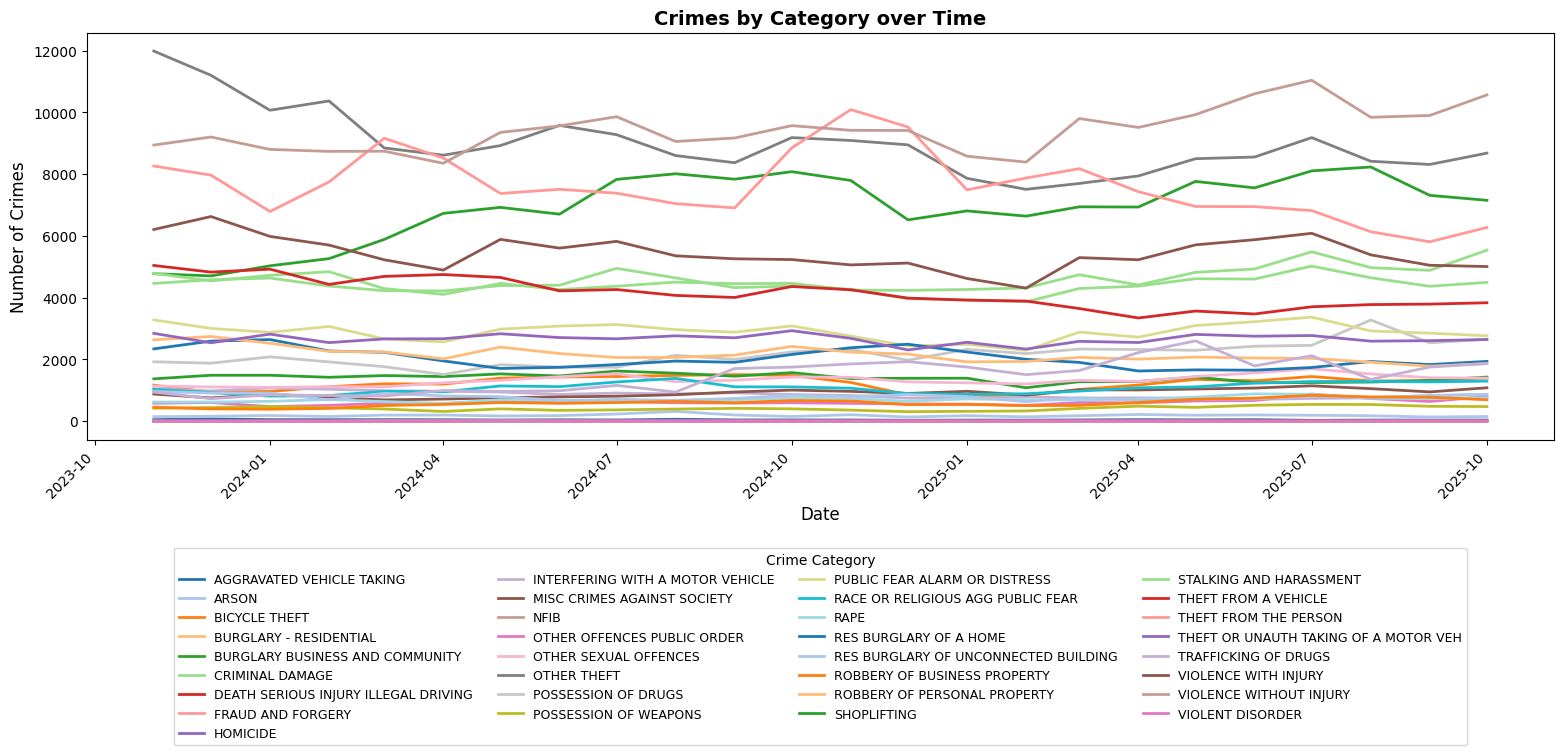

In [49]:
# use a colormap with many distinct colors (tab20) and map it to the number of series
n = minor_pivot.shape[0]
cmap = plt.get_cmap('tab20')

# get list of colors from cmap (handle both ListedColormap and continuous cmap)
base_colors = getattr(cmap, "colors", [cmap(i / max(1, n - 1)) for i in range(n)])
colors = [base_colors[i % len(base_colors)] for i in range(n)]

fig, ax = plt.subplots(figsize=(16, 8))
minor_pivot.T.plot(ax=ax, linewidth=2, color=colors)
ax.set_title('Crimes by Category over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Crimes', fontsize=12)
ax.tick_params(axis='x', rotation=45)

# Place legend below the plot in multiple columns for better symmetry
ax.legend(title='Crime Category', 
          bbox_to_anchor=(0.5, -0.25), 
          loc='upper center', 
          ncol=4, 
          frameon=True,
          fontsize=9)

plt.tight_layout()
plt.show()

## Specific Crime Type Time Series Visualization

Time series analysis reveals distinct patterns across 34 specific crime types. High-volume categories include Violence Without Injury (~10,000-11,000 monthly), Other Theft (~9,000-10,000), and Shoplifting (~7,000-8,000), which collectively drive overall crime trends. Most crime types show relative stability with moderate seasonal fluctuations, while lower-volume offenses (e.g., Homicide, Rape, Weapons Possession) remain consistently below 2,000 incidents per month.

## Ward-Level Crime Aggregation

Group crime data by ward and major crime category across all time periods to enable geographical analysis and ward-level comparisons.

In [50]:
loc_crime = df.groupby(['WardName', 'Crime Category'])[dates].sum().reset_index()
loc_crime.head()


,WardName,Crime Category,2023-11-01 00:00:00,2023-12-01 00:00:00,2024-01-01 00:00:00,2024-02-01 00:00:00,2024-03-01 00:00:00,2024-04-01 00:00:00,2024-05-01 00:00:00,2024-06-01 00:00:00,...,2025-01-01 00:00:00,2025-02-01 00:00:00,2025-03-01 00:00:00,2025-04-01 00:00:00,2025-05-01 00:00:00,2025-06-01 00:00:00,2025-07-01 00:00:00,2025-08-01 00:00:00,2025-09-01 00:00:00,2025-10-01 00:00:00
0,Abbey,ARSON AND CRIMINAL DAMAGE,11,8,16,9,12,13,9,9,...,11,8,8,10,12,6,15,22,11,10
1,Abbey,BURGLARY,18,3,15,7,18,10,9,5,...,11,7,6,6,6,12,9,6,8,11
2,Abbey,DRUG OFFENCES,14,7,16,7,11,5,9,11,...,9,12,15,27,18,14,9,21,11,17
3,Abbey,FRAUD AND FORGERY,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,Abbey,MISCELLANEOUS CRIMES AGAINST SOCIETY,2,4,1,0,0,3,3,1,...,2,3,1,3,1,1,3,0,1,1


In [52]:
# Save the cleaned and processed dataset
df.to_csv('../data/clean/processed_crime_data.csv', index=False)
print(" Processed data saved to: data/clean/processed_crime_data.csv")
print(f" Shape: {df.shape}")
print(f" File size: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB") #RAM usage during processing

 Processed data saved to: data/clean/processed_crime_data.csv
 Shape: (18693, 29)
 File size: 9.03 MB


## Notes

* Notebook sections can be expanded to support specific project requirements and analytical workflows.
* All cells must execute sequentially from top to bottom without requiring backward navigation or variable re-initialization.

### GitHub Rendering Issue

**Problem**: This notebook fails to render in GitHub's web viewer, displaying only a blank page.

**Investigation**: To diagnose the issue, we performed file size checks:

**Notebook File Size** (using `ls -lh jupyter_notebooks/ETL.ipynb`):
* Result: **388 KB**
* Includes all code, markdown, and embedded visualization outputs
* Well within GitHub's 100MB file size limit

**DataFrame Memory Usage** (using `df.memory_usage(deep=True).sum()`):
* Result: **9.03 MB**
* Represents RAM consumption during data processing
* Not directly related to file rendering

**Output CSV File Size** (using `ls -lh data/clean/processed_crime_data.csv`):
* Result: **2.3 MB**
* Confirms successful data processing and export

**Conclusion**: The 388KB file size is reasonable and should render without issues. The root cause remains unclear but is likely related to GitHub's rendering infrastructure limitations rather than the notebook itself.

**Attempted Solutions**:
* NBViewer links were initially provided as an alternative, but these also fail to render the notebook consistently
* The "Raw" button on GitHub shows the notebook's JSON structure but is not user-friendly

**Verified Solution**: The notebook opens and executes successfully in local environments (VS Code, JupyterLab, Jupyter Notebook). Users experiencing rendering issues should clone the repository and run the notebook locally.